# "Chapter 4: Text versus Bytes"

> more about str and byte

- toc:true
- badges: true
- author: JJmachan

## Charecter Issue

Now the best definition of what a Charater is, is its Unicode representation. The Unicode standard explicitly seperates the identity of charaters from its bytes representation. 

The identity of the character is its code point (ie in the form U+000000). For example A is U+0041.

The actual bytes representation depends on the encoding that is used. If we use UTF-8 encoding, the byte representation of A is \x41 but if we use UTF-16LE it is \x41\x00

*Coverting from code points to bytes is called __encoding__ and from bytes to code points is called __decoding__*

In [1]:
s = 'café'
len(s)

4

In [2]:
# encode to utf-8
b = s.encode('utf_8')
b

b'caf\xc3\xa9'

In [4]:
# decode back to codepoints
len(b), b.decode('utf8')

(5, 'café')

## Byte Essentials

There are 2 basic build-in types for binary sequence, the immutable `bytes` type and the mutable `bytearray`. Each item in both is an integer from 0-255

In [5]:
cafe = bytes('café', encoding='utf_8')
cafe

b'caf\xc3\xa9'

In [6]:
len(cafe)

5

In [7]:
cafe[0]

99

In [8]:
for i in range(len(cafe)):
    print(cafe[i])

99
97
102
195
169


In [9]:
cafe[:1]

b'c'

In [10]:
cafe_arr = bytearray(cafe)
cafe_arr

bytearray(b'caf\xc3\xa9')

In [11]:
cafe_arr[-1:]

bytearray(b'\xa9')

In [12]:
len(cafe_arr)

5

As you can see, even though the binary sequence is sequence of integers, they are displayed on each byte value. ASCII text and espace squences are displayed as its is while all other bytes use a hexadecimal escape sequence.

Both bytes and bytearray support every str method except those that do formatting
( format , format_map ) and a few others that depend on Unicode data, including case
fold , isdecimal , isidentifier , isnumeric , isprintable , and encode . This means that
you can use familiar string methods like endswith , replace , strip , translate , upper ,
and dozens of others with binary sequences—only using bytes and not str arguments.
In addition, the regular expression functions in the re module also work on binary
sequences, if the regex is compiled from a binary sequence instead of a str .

A `byte` or `bytearray` can be build in many ways like 
1. using the constructors calling classmethods like `byte.fromhex()`
2. A `str` and an `encoding` keyword argument.
3. An iterable providing items with values from 0 to 255.
4. An object that implements the buffer protocol (e.g., bytes, bytearray, memory
view, array.array); this copies the bytes from the source object to the newly created binary sequence.

In [16]:
# class method `fromhex`
b = bytes.fromhex('31 4B CE A9')
print(b)

# from an object that implements the buffer protocol
import array
# 'h' denotes short integers
nums = array.array('h', [-2, -1, 0, 1, 2])
octets = bytes(nums)
print(octets)

# from iterable
b = bytes([65, 66, 67])
print(b)

b'1K\xce\xa9'
b'\xfe\xff\xff\xff\x00\x00\x01\x00\x02\x00'
b'ABC'


Creating bytes/bytearray from buffer like source will always copy the bytes. In contrast `memoryview` objects let you share memory between both. To extract structured information from the binary source use the `struct` module. 

### Structs and Memory Views
To show the power of struct and memoryview let see an example were we 
took at the header of a gif file.

In [22]:
import struct
# format of the bytes string (gif header)
fmt = '<3s3sHH'
with open('leo.gif', 'rb') as fp:
    img = memoryview(fp.read())
    
header = img[:10]  # creates a new memory view for only the headers
bytes(header), header

(b'GIF89aX\x02\x90\x01', <memory at 0x7f4d9050c400>)

In [23]:
struct.unpack(fmt, header)

(b'GIF', b'89a', 600, 400)

In [24]:
del header
del img

## Encoder/Decoder

Pythons comes with 100s of basic encoders and decoder that are used to handle the different types commonly seen in the wild. Here is an example of a string encoded with 3 different codecs producing very different results.

In [1]:
for codec in ['latin_1', 'utf_8', 'utf_16']:
    print(codec, 'El Niño'.encode(codec), sep='\t')

latin_1	b'El Ni\xf1o'
utf_8	b'El Ni\xc3\xb1o'
utf_16	b'\xff\xfeE\x00l\x00 \x00N\x00i\x00\xf1\x00o\x00'


### Problems you might encounter
Python throws a encoding or decoding error `UnicodeEnodeError` or `UnicodeDecodeError`. We will look into how to handle these. It can also raise a `SyntaxException` when the source encoding is unexpected.

#### UnicodeEncodeError
Most not-utf codecs only handle a small subset of chars. This error is raised when converting from text to bytes and a char is not supported by the codec. 

In [2]:
city = 'São Paulo'
city.encode('utf_8')

b'S\xc3\xa3o Paulo'

In [3]:
city.encode('utf_16')

b'\xff\xfeS\x00\xe3\x00o\x00 \x00P\x00a\x00u\x00l\x00o\x00'

In [4]:
city.encode('cp437')

UnicodeEncodeError: 'charmap' codec can't encode character '\xe3' in position 1: character maps to <undefined>

The `error` argument however gives you options on how to handle these errors.

In [5]:
city.encode('cp437', errors='ignore')

b'So Paulo'

In [6]:
city.encode('cp437', errors='replace')

b'S?o Paulo'

In [7]:
city.encode('cp437', errors='xmlcharrefreplace')

b'S&#227;o Paulo'

#### UnicodeDecodeError

Not every byte holds a valid ASCII char and not every byte sequence is a valid UTF-8 so if you assume a perticular encoding while converting a binary sequence to text you will get a `UnicodeDecodeError` if unexpected bytes are encountered. 

But some leagacy enodings like `cp1252` are able to decode any stream of bytes and hence no errors are generated even though the output might be junk.

In [8]:
# ecoded in latin1
octets = b'Montr\xe9al'
octets.decode('cp1252')

'Montréal'

In [9]:
octets.decode('iso8859_7')

'Montrιal'

In [10]:
octets.decode('utf_8')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 5: invalid continuation byte

In [11]:
octets.decode('utf_8', errors='replace')

'Montr�al'

### SyntaxError when loading Modules with Unexpected Encodings

UTF-8 is the default encoding of Python 3 and if your code contains anything else and there is no encoding declaration it will throw an error.
You can use the `coding` command to provide the expected encoding of the module.
```
# coding: cp1252
print('Olá, Mundo!')
```

Now coming to whether we should use non-ASCII identifier in source code is a personal choice. Preference should be given to people who is most likely to read and write the codebase more often and you should optimize for that.

### How to Discover the Encoding of a Byte Sequence

in short, you can't, you have to be told. There are tools like `Chardet - The Universal Charater Encoding Detector` that works to detect the encoding with some assumptions.

### BOM: A Useful Gremlin

You may notice an couple of extra bytes at the beginning of UTF-16 encoded sequence. The bytes '\xff\xfe' are used to denote little endian/big endian.

In [12]:
u16 = 'El Niño'.encode('utf_16')
u16

b'\xff\xfeE\x00l\x00 \x00N\x00i\x00\xf1\x00o\x00'

## Handling Text Files

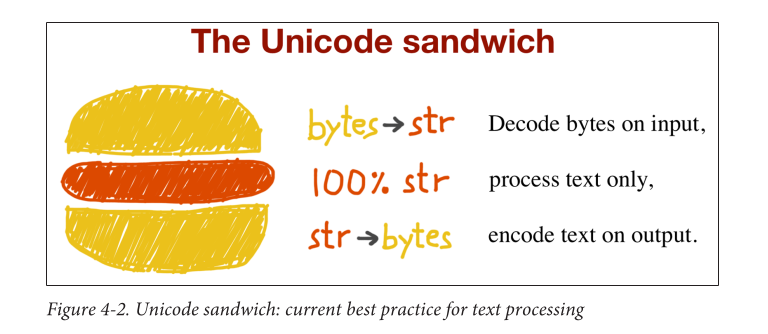

This diagram shows the best practice for handling text. This means bytes should be decoded to str as early as possible and the entire "meat" or buisness logic should happen with str objects. Then the encoding back to bytes is kept as late as possible. This idea is incorporated in most frameworks (eg Django which handles everything in UTF).

Python 3 makes this easier to follow because `open` built-in does the necessary encoding and decoding so that you always handle strings.

do not code that has to run on mulitple machines should never assume encoding/decoding defaults because it may change from machine to machine and cause bugs.

## Normalizing Unicode for Saner Comparison

Comparing differenet string, event different Unicode string can get complicated. It is always recommended to normalize texts before doing operations like comparisons on them